In [113]:
# !pip install numpy pyarrow fastparquet scipy scikit-learn

In [114]:
import numpy, scipy, pandas as pd, os
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression as lr

In [115]:
# JAN 
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet

# FEB
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

In [116]:
df_jan = pd.read_parquet('1_data/yellow_tripdata_2023-01.parquet')
# df_feb = pd.read_parquet('1_data/yellow_tripdata_2023-02.parquet')

In [117]:
# df_jan


In [118]:
df_jan.shape

(3066766, 19)

In [119]:
df_jan.shape

(3066766, 19)

In [120]:
df_jan.tpep_pickup_datetime = pd.to_datetime(df_jan.tpep_pickup_datetime)
df_jan.tpep_dropoff_datetime = pd.to_datetime(df_jan.tpep_dropoff_datetime)
# tpep_dropoff_datetime

In [121]:
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime

In [122]:
# df_jan.duration.describe()

In [123]:
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

In [124]:
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration >= 60)]


In [125]:
df_jan.duration.describe()

count    24301.000000
mean       218.135302
std        418.515838
min         60.000000
25%         63.450000
50%         68.450000
75%         79.583333
max      10029.183333
Name: duration, dtype: float64

In [126]:
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration >= 60)]


In [127]:
df_jan.duration.describe()

count    24301.000000
mean       218.135302
std        418.515838
min         60.000000
25%         63.450000
50%         68.450000
75%         79.583333
max      10029.183333
Name: duration, dtype: float64

In [128]:
# FEATURES

# Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

# Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
# Fit a dictionary vectorizer
# Get a feature matrix from it
# What's the dimensionality of this matrix (number of columns)?

In [129]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [130]:
df_jan[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [131]:
df_jan[categorical] = df_jan[categorical].astype(str)

In [132]:
df_jan[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [133]:
df_jan[numerical].dtypes

trip_distance    float64
dtype: object

In [134]:
dv = DictVectorizer()

In [135]:
train_dicts = df_jan[categorical + numerical].to_dict(orient='records')
# train_dicts = df_jan[categorical].to_dict(orient='records')

In [136]:
x_train = dv.fit_transform(train_dicts)

In [137]:
x_train

<24301x486 sparse matrix of type '<class 'numpy.float64'>'
	with 72903 stored elements in Compressed Sparse Row format>

In [138]:
# dv.feature_names_

In [139]:
target = 'duration'

In [140]:
y_train = df_jan[target].values

In [141]:
y_train

array([  68.1       , 1421.1       , 1376.76666667, ...,   64.13333333,
         66.78333333,   73.        ])

In [142]:
# Q5. Training a model
# Now let's use the feature matrix from the previous step to train a model.

# Train a plain linear regression model with default parameters, where duration is the response variable
# Calculate the RMSE of the model on the training data
# What's the RMSE on train?

# 3.64
# 7.64
# 11.64
# 16.64

In [152]:
lr = lr()

In [154]:
lr.fit(x_train, y_train)

LinearRegression()

In [155]:
y_pred = lr.predict(x_train)

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

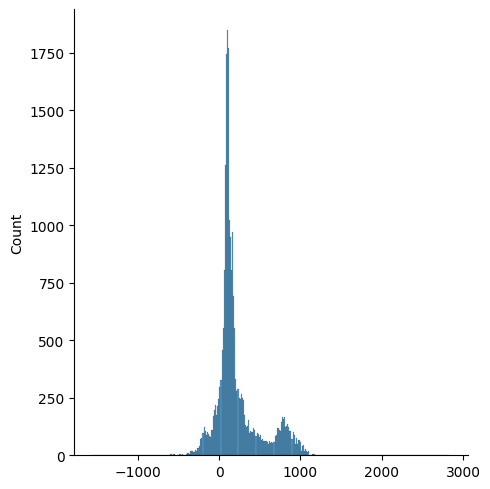

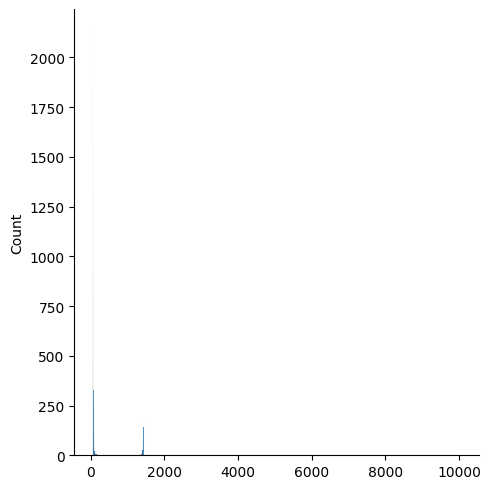

In [169]:
sns.displot(y_pred, label = 'prediction')
sns.displot(y_train, label = 'actual')
# plt.legend()

In [170]:
# plt.hist(y_pred, alpha=0.5, label='prediction', density=True)

# # Plot the actual distribution
# plt.hist(y_train, alpha=0.5, label='actual', density=True)

# # Add legend
# plt.legend()

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.title('Distribution of Predictions and Actual Values')

# # Show the plot
# plt.show()

In [176]:
from sklearn.metrics import mean_squared_error as msr 
# function'root_mean_squared_error

In [177]:
msr(y_train, y_pred, squared=False)

/workspaces/codespaces-blank/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


309.9382458277888